## Find stellar multiples by radial velocity variations

In [24]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
from scipy.special import logsumexp
from matplotlib.ticker import MaxNLocator

import sys
sys.path.insert(0, "../")

import velociraptor

%matplotlib inline

In [13]:
sources = velociraptor.load_gaia_sources("../data/rv-all-subset-1e4.fits")

../velociraptor.py:40: RuntimeWarning: invalid value encountered in log10
  + 5 * np.log10(sources["parallax"]/100.0)


(3000, 8000)

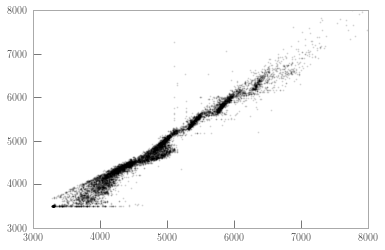

In [10]:
ridx = np.random.choice(len(sources), 10000, False)
fig, ax = plt.subplots()
ax.scatter(sources["teff_val"][ridx],
           sources["approx_teff_from_bp_rp"][ridx],
           s=1, alpha=0.1, c="k")
ax.set_xlim(3000, 8000)
ax.set_ylim(3000, 8000)

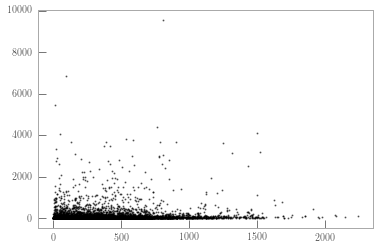

In [15]:
#ridx = np.random.choice(len(sources), 100000, False)
ridx = np.ones(len(sources), dtype=bool)

sources["rv_diff_template_teff"] = np.abs(
    sources["rv_template_teff"] - sources["approx_teff_from_bp_rp"])

fig, ax = plt.subplots()
ax.scatter(sources["rv_diff_template_teff"][ridx],
           sources["rv_single_epoch_variance"][ridx],
           s=1, alpha=0.5, c="k")


In [22]:
def plot_average_grid_value(x, y, z, bins=(100, 100), function=np.nanmedian,
                            ax=None, xlabel=None, ylabel=None, zlabel=None,
                            colorbar=True, **kwargs):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    else:
        fig = ax.figure
    
    finite = np.isfinite(x * y * z)
    x_, y_, z_ = (x[finite], y[finite], z[finite])
    H, xedges, yedges = np.histogram2d(x_, y_, bins=bins)
    
    x_indices = np.digitize(x_, xedges) - 1
    y_indices = np.digitize(y_, yedges) - 1
    
    Z = np.nan * np.ones_like(H) 
    for i in range(xedges.size - 1):
        for j in range(yedges.size - 1):
            match = (x_indices == i) * (y_indices == j)
            try:
                _ = function(z_[match])
                
            except ValueError:
                continue
                
            else:
                Z[i, j] = _

    imshow_kwds = dict(
        aspect=np.ptp(xedges)/np.ptp(yedges), 
        extent=(xedges[0], xedges[-1], yedges[-1], yedges[0]),
        cmap="viridis"
    )
    imshow_kwds.update(kwargs)

    image = ax.imshow(Z.T, **imshow_kwds)
    if colorbar:
        cbar = plt.colorbar(image)
        cbar.set_label(zlabel)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.xaxis.set_major_locator(MaxNLocator(6))
    ax.yaxis.set_major_locator(MaxNLocator(6))

    fig.tight_layout()
    
    return fig



/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


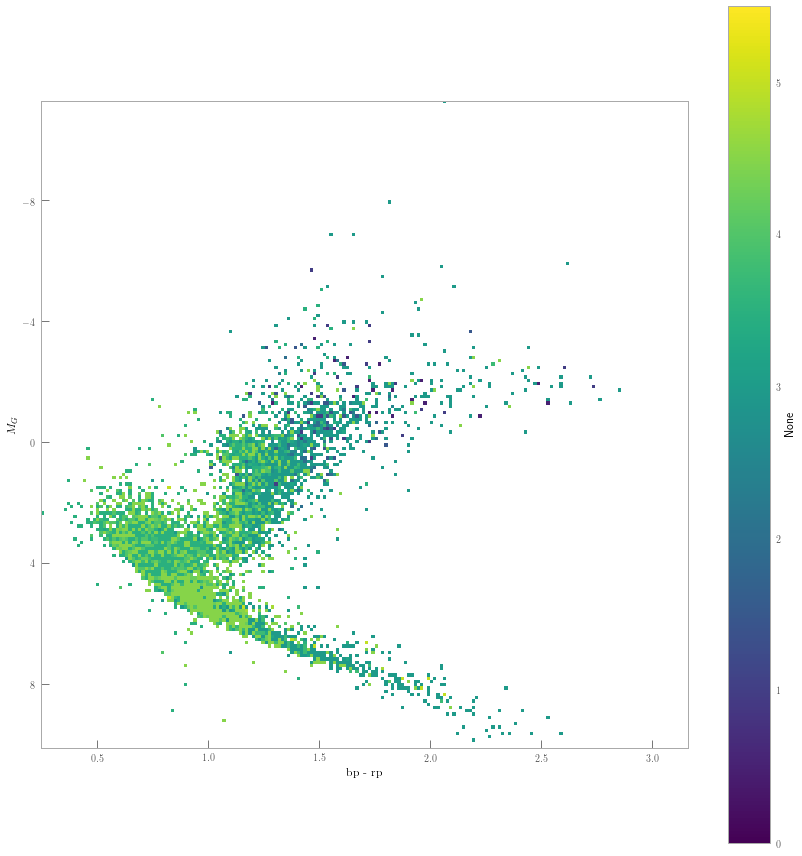

In [43]:
# Colour by the log of the median rv error in each grid point.
fig = plot_average_grid_value(sources["bp_rp"],
                              sources["absolute_g_mag"],
                              sources["rv_template_logg"],
                              function=lambda _: np.nanmedian(_),
                              xlabel=r"\textrm{bp - rp}",
                              ylabel=r"$M_G$", bins=200, vmin=0, vmax=5.5)



In [16]:
def design_matrix_function(phot_rp_mean_flux, bp_rp, rv_diff_template_teff, **kwargs):
    """
    Design matrix for the mean and sigma of the intrinsic radial velocity jitter.
    """
    return np.array([
        np.ones(len(phot_rp_mean_flux)),
        phot_rp_mean_flux**-1,
        phot_rp_mean_flux**-2,
        bp_rp**-1,
        bp_rp**-2,
    ])
    

# Only perform the fitting with high latitude stars that have less
# risk of sky confusion
mask = (np.abs(sources["b"]) >= 30) \
     * np.isfinite(sources["radial_velocity"]) \

model, data_dict, init_dict, used_in_model_fit = velociraptor.prepare_model(
    S=1e4, model_path="../model.stan", 
    mask=mask,
    design_matrix_function=design_matrix_function, **sources)

print("Number of data points: {}".format(data_dict["N"]))

init_dict = dict([
    ('theta', 0.15167079461165178),
    ('mu_coefficients', np.array([2.1465e-05, 1.4585e+02, 2.0827e+11,
        7.7332e-08, 5.8626e+00])), 
    ('sigma_coefficients', np.array([7.4405e-04, 3.9762e-01, 1.7293e+11,
        4.1103e-04, 5.9489e+00])),
])

INFO:root:Using pre-compiled model from ../model.stan.cached


Number of data points: 10000


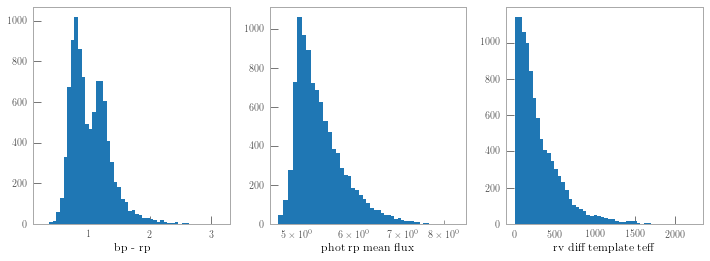

In [17]:
relevant_label_names = ("bp_rp", "phot_rp_mean_flux", "rv_diff_template_teff")
latex_label_names = dict(
    bp_rp=r"\textrm{bp - rp}",
    phot_rp_mean_flux=r"\textrm{phot rp mean flux}",
    rv_diff_template_teff=r"\textrm{rv diff template teff}",
    rv_single_epoch_variance=r"\textrm{rv single epoch variance}"
)

use_semilogx = dict(phot_rp_mean_flux=True)


K = len(relevant_label_names)
fig, axes = plt.subplots(1, K, figsize=(4 * K, 4))
for k, (ax, ln) in enumerate(zip(axes, relevant_label_names)):
    v = sources[ln][used_in_model_fit]
    if use_semilogx.get(ln, False):
        v = np.log10(v)
        
    ax.hist(v, bins=50)
    ax.set_xlabel(latex_label_names.get(ln))
    
    if use_semilogx.get(ln, False):
        ax.semilogx()


In [18]:
kwds = dict(
    data=data_dict,
    init=init_dict,
    iter=100000, 
    tol_obj=7./3 - 4./3 - 1, # machine precision
    tol_grad=7./3 - 4./3 - 1, # machine precision
    tol_rel_grad=1e3,
    tol_rel_obj=1e4
)
p_opt = model.optimizing(**kwds)

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:362: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(np.asarray(v).dtype, int):
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


AssertionError: 

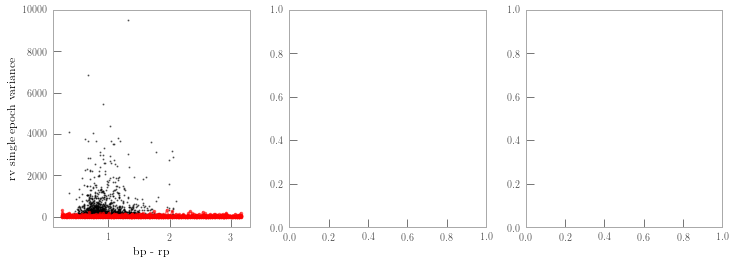

In [19]:
ylabel_name = "rv_single_epoch_variance"

D = 10 # number of draws of other parameters.
P = 100 # number of points

K = len(relevant_label_names)
fig, axes = plt.subplots(1, K, figsize=(4*K, 4))
for k, (ax, label_name) in enumerate(zip(axes, relevant_label_names)):
    
    x = sources[label_name][used_in_model_fit]
    y = sources[ylabel_name][used_in_model_fit]
    
    ax.scatter(x, y, s=1, c="#000000", alpha=0.5)

    # These should all be finite if they are used in the model fit,
    # but fuck it.
    x_finite = np.isfinite(x)
    
    xi = np.linspace(np.min(x[x_finite]), np.max(x[x_finite]), P)
    # make draws from other labels.
    for d in range(D):
        dm_dict = dict([(label_name, xi)])
        for ln in set(relevant_label_names).difference([label_name]):
            _ = sources[ln]
            dm_dict[ln] = np.random.choice(_[np.isfinite(_)], P, 
                                           replace=False)
        
        dm = design_matrix_function(**dm_dict)
        
        jitter_mu = np.dot(p_opt["mu_coefficients"], dm)
        jitter_sigma = np.dot(p_opt["sigma_coefficients"], dm)
                
        ax.plot(xi, jitter_mu + np.random.normal(0, 1) * jitter_sigma,
                c='r', alpha=0.5, zorder=10)
        
        
    ax.set_xlabel(latex_label_names.get(label_name))
    ax.set_ylabel(latex_label_names.get(ylabel_name))
    if use_semilogx.get(label_name, False):
        ax.semilogx()
    break

assert 0

In [ ]:
print(xi.shape)
print(yi.shape)

In [ ]:



"""
sampled_model = model.sampling(**velociraptor.stan.sampling_kwds(
    data=data_dict, chains=2, iter=2000, init=p_opt))

samples = sampled_model.extract(("theta", "mu_coefficients", 
    "sigma_coefficients", "log_membership_probability"))

with open("model-sampled.pkl", "wb") as fp:
    pickle.dump(samples, fp, -1)
"""


# Calculate probabilities.
# SB1: From what Gaia doesn't tell us.
is_sb1 = (sources["phot_rp_mean_mag"] <= 12.8) \
       * (~np.isfinite(sources["radial_velocity"]))

sources["p_sb1"] = np.zeros(len(sources), dtype=float)
sources["p_sb1"][is_sb1] = 1.0

# SB2: From our model.
# In case I want to change this later to take the mean from a trace or something
_point_estimate = lambda k: p_opt[k]

log_ps1 = _point_estimate("log_ps1")

# Get the design matrix and single epoch rv variance for ALL stars.
dm = velociraptor._rvf_design_matrix(**sources).T
rv_variance = sources["rv_single_epoch_variance"]

mu = np.dot(dm, _point_estimate("mu_coefficients"))
ivar = np.dot(dm, _point_estimate("sigma_coefficients"))**-2
log_ps2 = np.log(1 - _point_estimate("theta")) \
        - 0.5 * np.log(2 * np.pi) + 0.5 * np.log(ivar) \
        - 0.5 * (rv_variance - mu)**2 * ivar

log_sb2 = log_ps1 - logsumexp([log_ps1 * np.ones(dm.shape[0]), log_ps2], axis=0)
sources["p_sb2"] = np.exp(log_sb2)

# Calculate the max of those two probabilities.
sources["p_sbx"] = np.nanmax([sources["p_sb1"], sources["p_sb2"]], axis=0)

# Calculate the excess variance.
sources["excess_rv_variance"] = np.max(
    [rv_variance - mu, np.zeros(rv_variance.size)], axis=0)
#sources["excess_rv_variance"][~np.isfinite(sources["excess_rv_variance"])] = 0
sources["excess_rv_sigma"] = sources["excess_rv_variance"]**0.5


# Load the data and make some plots.
sources = velociraptor.load_gaia_sources("data/rv-all.fits")
model, data_dict, init_dict, idx = velociraptor.prepare_model(S=1e4, **sources)

print("Number of data points: {}".format(data_dict["N"]))

init_dict = dict([
    ('theta', 0.15167079461165178),
    ('mu_coefficients', np.array([2.1465e-05, 1.4585e+02, 2.0827e+11,
        7.7332e-08, 5.8626e+00])), 
    ('sigma_coefficients', np.array([7.4405e-04, 3.9762e-01, 1.7293e+11,
        4.1103e-04, 5.9489e+00])),
])

p_opt = model.optimizing(data=data_dict, init=init_dict)

with open("model-optimized.pkl", "wb") as fp:
    pickle.dump(p_opt, fp, -1)

print(p_opt)
"""
sampled_model = model.sampling(**velociraptor.stan.sampling_kwds(
    data=data_dict, chains=2, iter=2000, init=p_opt))

samples = sampled_model.extract(("theta", "mu_coefficients", 
    "sigma_coefficients", "log_membership_probability"))

with open("model-sampled.pkl", "wb") as fp:
    pickle.dump(samples, fp, -1)
"""


# Calculate probabilities.
# SB1: From what Gaia doesn't tell us.
is_sb1 = (sources["phot_rp_mean_mag"] <= 12.8) \
       * (~np.isfinite(sources["radial_velocity"]))

sources["p_sb1"] = np.zeros(len(sources), dtype=float)
sources["p_sb1"][is_sb1] = 1.0

# SB2: From our model.
# In case I want to change this later to take the mean from a trace or something
_point_estimate = lambda k: p_opt[k]

log_ps1 = _point_estimate("log_ps1")

# Get the design matrix and single epoch rv variance for ALL stars.
dm = velociraptor._rvf_design_matrix(**sources).T
rv_variance = sources["rv_single_epoch_variance"]

mu = np.dot(dm, _point_estimate("mu_coefficients"))
ivar = np.dot(dm, _point_estimate("sigma_coefficients"))**-2
log_ps2 = np.log(1 - _point_estimate("theta")) \
        - 0.5 * np.log(2 * np.pi) + 0.5 * np.log(ivar) \
        - 0.5 * (rv_variance - mu)**2 * ivar

log_sb2 = log_ps1 - logsumexp([log_ps1 * np.ones(dm.shape[0]), log_ps2], axis=0)
sources["p_sb2"] = np.exp(log_sb2)

# Calculate the max of those two probabilities.
sources["p_sbx"] = np.nanmax([sources["p_sb1"], sources["p_sb2"]], axis=0)

# Calculate the excess variance.
sources["excess_rv_variance"] = np.max(
    [rv_variance - mu, np.zeros(rv_variance.size)], axis=0)
#sources["excess_rv_variance"][~np.isfinite(sources["excess_rv_variance"])] = 0
sources["excess_rv_sigma"] = sources["excess_rv_variance"]**0.5
